In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['marketing-funnel-olist', 'brazilian-ecommerce']


# Settings
---

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
sns.set_style('whitegrid', {'grid.linestyle': '--'})

%matplotlib inline

# Objectives
---
In this kernel I am covering three subjects with data of the Brazilian ecommerce marketplace, Olist.
1. Marketing Channel Effectiveness
2. Sales Performance Overview
3. Closed Deal Performance Overview

## 1. Marketing Channel Effectiveness
---
Olist acquired sellers through diverse marketing channels. Let's find out which channel was the most effective in lead generation. Below the term 'Marketing Qualified Lead(MQL)' means a potential reseller/manufacturer who has an interest in selling their products on Olist. 

In [3]:
# Load 'MQL' dataset
mql = pd.read_csv('../input/marketing-funnel-olist/olist_marketing_qualified_leads_dataset.csv',
                  parse_dates=['first_contact_date'])

print(mql.shape)
mql.head(3)

(8000, 4)


,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search


### Time Series Volume of Marketing Qualified Lead (MQL)

In [4]:
# Add a 'year-month' column
mql['first_contact_date(y-m)'] = mql['first_contact_date'].dt.to_period('M')

print(mql.shape)
mql[['first_contact_date', 'first_contact_date(y-m)']].head(3)

(8000, 5)


,first_contact_date,first_contact_date(y-m)
0,2018-02-01,2018-02
1,2017-10-20,2017-10
2,2018-03-22,2018-03


In [5]:
# Create time series table
monthly_mql = mql.groupby(by='first_contact_date(y-m)').mql_id \
                                                       .count()
monthly_mql.to_frame().T

first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
mql_id,4,239,386,312,416,445,200,1141,1028,1174,1352,1303


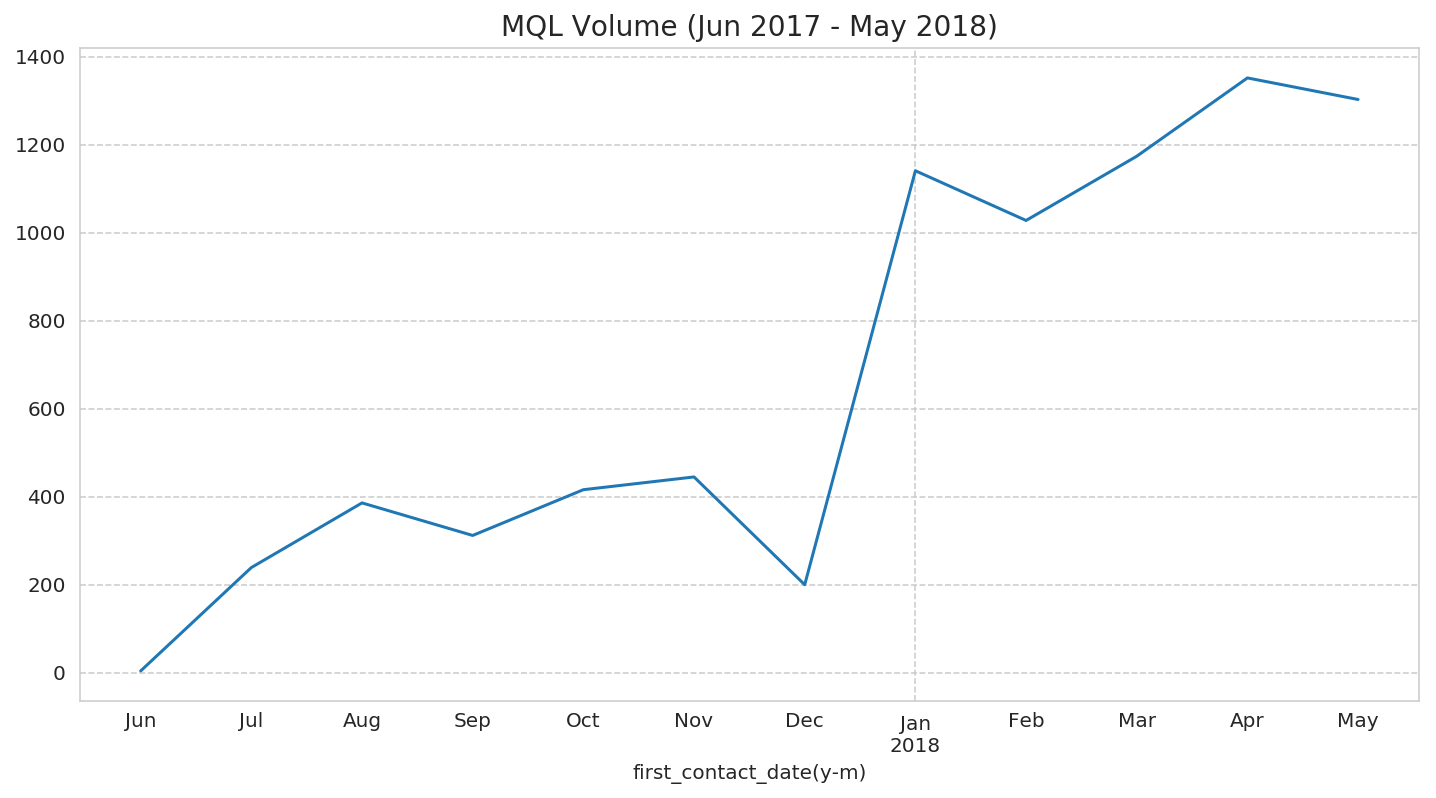

In [6]:
# Plot the monthly MQL volume
monthly_mql.plot.line(figsize=(12, 6))
plt.title('MQL Volume (Jun 2017 - May 2018)', fontsize=14);

Since 2018, monthly MQL volume soared to above 1,000. Let's take a look at the volume for each acquisition channel.

### MQL Volume by Marketing Channel
_\* Marketing channel is recorded in 'origin' field._

In [7]:
# Create 'channel-time series' table
mql_origin = pd.pivot_table(mql,
                            index='origin',
                            columns='first_contact_date(y-m)',
                            values='mql_id',                            
                            aggfunc='count',
                            fill_value=0)

# Sort index from largest to smallest in volume
origin_list = mql.groupby('origin').mql_id \
                                   .count() \
                                   .sort_values(ascending=False) \
                                   .index

mql_origin = mql_origin.reindex(origin_list)
mql_origin

first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
origin,,,,,,,,,,,,
organic_search,0,54,122,78,125,121,60,412,291,340,349,344
paid_search,0,56,79,64,100,70,35,170,212,262,272,266
social,0,12,45,56,52,95,39,162,156,139,325,269
unknown,1,35,70,39,53,63,25,151,156,186,166,154
direct_traffic,0,16,22,22,23,26,10,82,65,80,75,78
email,1,19,24,23,30,37,12,61,68,74,50,94
referral,0,8,16,12,8,20,9,41,34,38,45,53
other,0,12,3,9,8,3,1,39,16,22,26,11
display,1,19,2,5,5,6,5,11,18,16,19,11


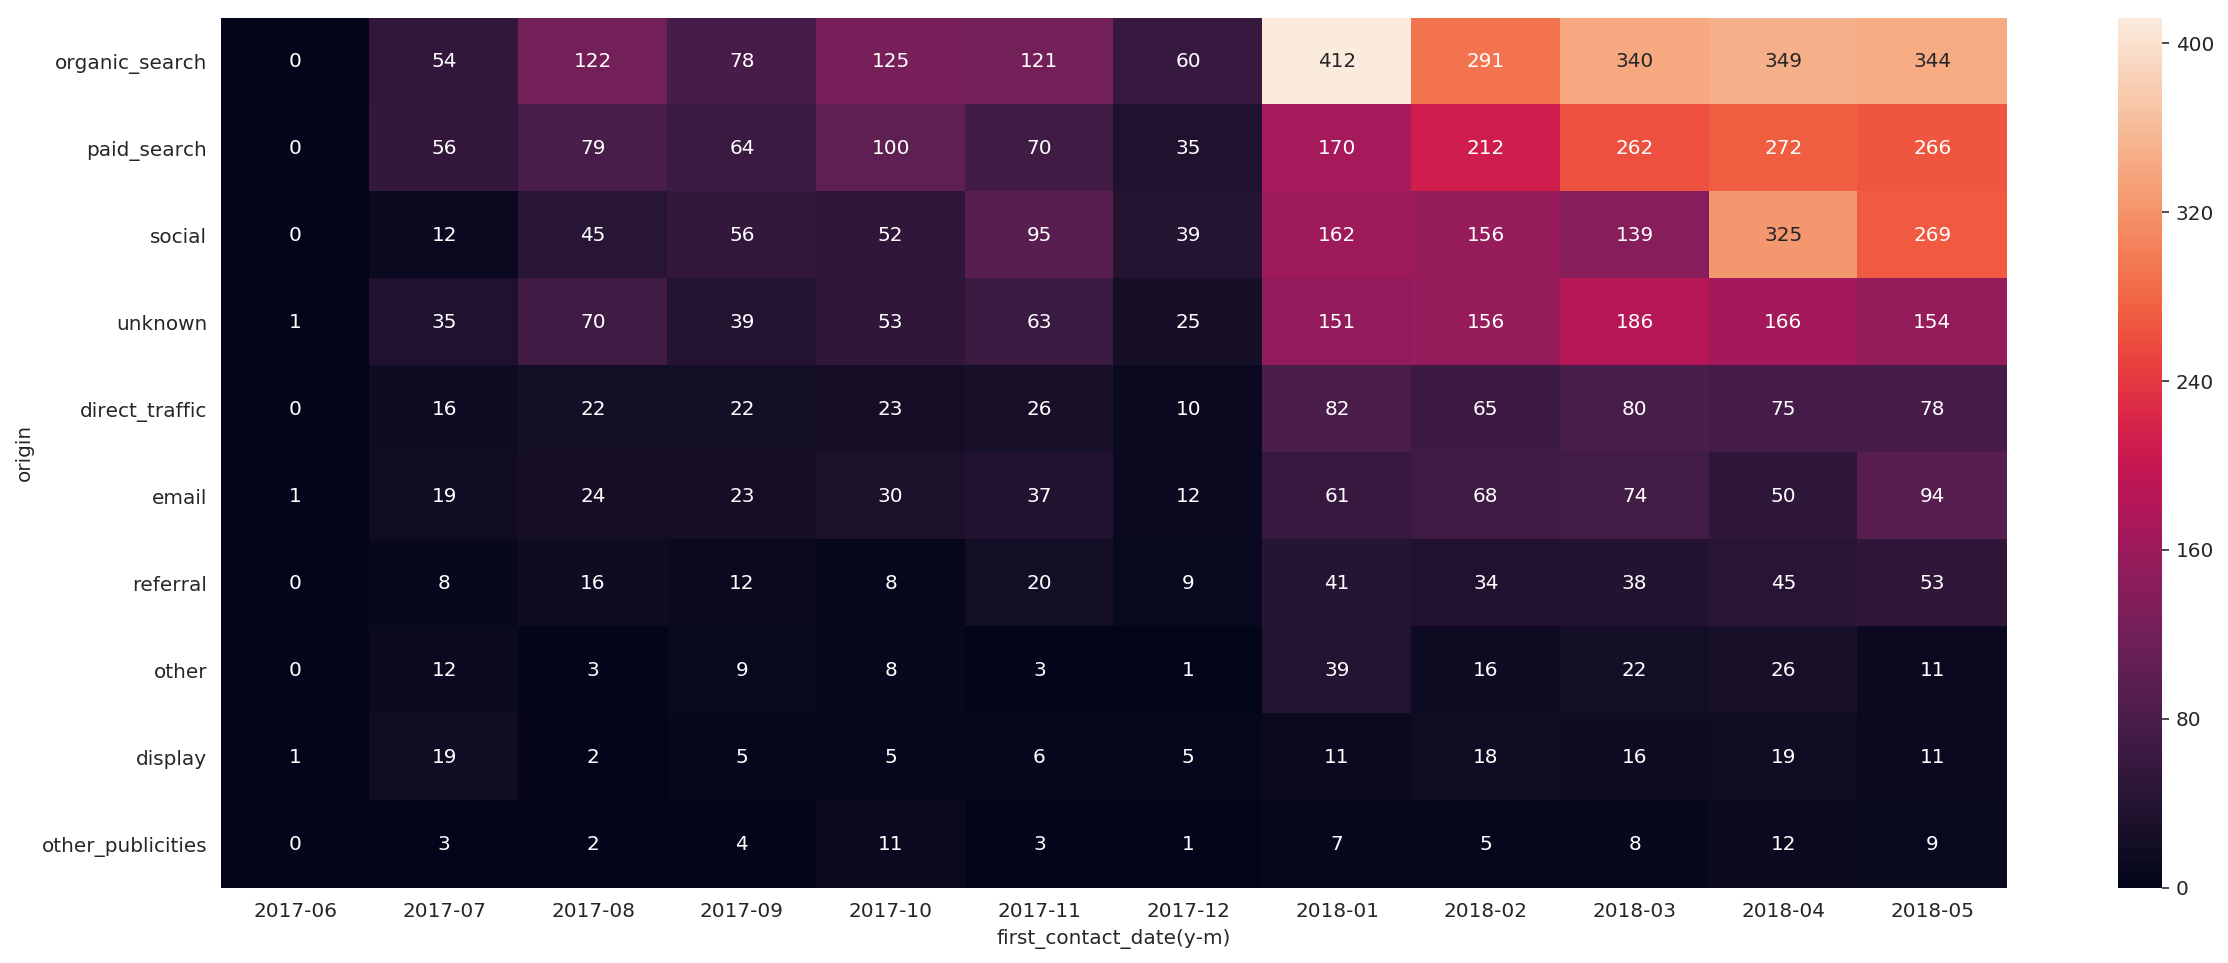

In [8]:
# Plot the monthly volume by channel
plt.figure(figsize=(20,8))
sns.heatmap(mql_origin, annot=True, fmt='g');

+ Paid search is the second biggest contributor to lead generation after 'organic search'.
+ The third one is 'social' which acquired MQLs more than or similar to 'paid search' since April 2018.
+ If the marginal cost of paid search increases, it would be possible to examine effectiveness of 'social' as an alternative.

## 2. Sales Performance Overview
---
After a MQL filled a form on landing page to sign up for seller, a Sales Development Representative(SDR) contacted the MQL and gathered more information about the lead. Then a Sales Representative(SR) consulted the MQL. So interaction between SDRs/SRs and MQLs can affect conversion from MQLs to sellers.  

At this section I will deal with two aspects of sales result, conversion rate and sales length.  
_\* A MQL who finally signed up for seller is called a closed deal._

In [9]:
# Load 'closed deals' dataset
cd = pd.read_csv('../input/marketing-funnel-olist/olist_closed_deals_dataset.csv',
                 parse_dates=['won_date'])

print(cd.shape)
cd.head(3)

(842, 14)


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0


In [10]:
# Merge 'MQL' with 'closed deals'
# Merge by 'left' in order to evaluate conversion rate
mql_cd = pd.merge(mql,
                  cd,
                  how='left',
                  on='mql_id')

print(mql_cd.shape)
mql_cd.head(3)

(8000, 18)


,mql_id,first_contact_date,landing_page_id,origin,first_contact_date(y-m),seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,2018-02,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,2017-10,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,2018-03,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Add a column to distinguish signed MOLs from MQLs who left without signing up
mql_cd['seller_id(bool)'] = mql_cd['seller_id'].notna()

print(mql_cd.shape)
mql_cd[['seller_id', 'seller_id(bool)']].head()

(8000, 19)


,seller_id,seller_id(bool)
0,NaN,False
1,NaN,False
2,NaN,False
3,NaN,False
4,2c43fb513632d29b3b58df74816f1b06,True


In [12]:
# Compute monthly closed deals
monthly_cd = mql_cd.groupby('first_contact_date(y-m)')['seller_id(bool)'].sum()
monthly_cd.to_frame().T

first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
seller_id(bool),0.0,2.0,9.0,7.0,14.0,18.0,11.0,152.0,149.0,167.0,183.0,130.0


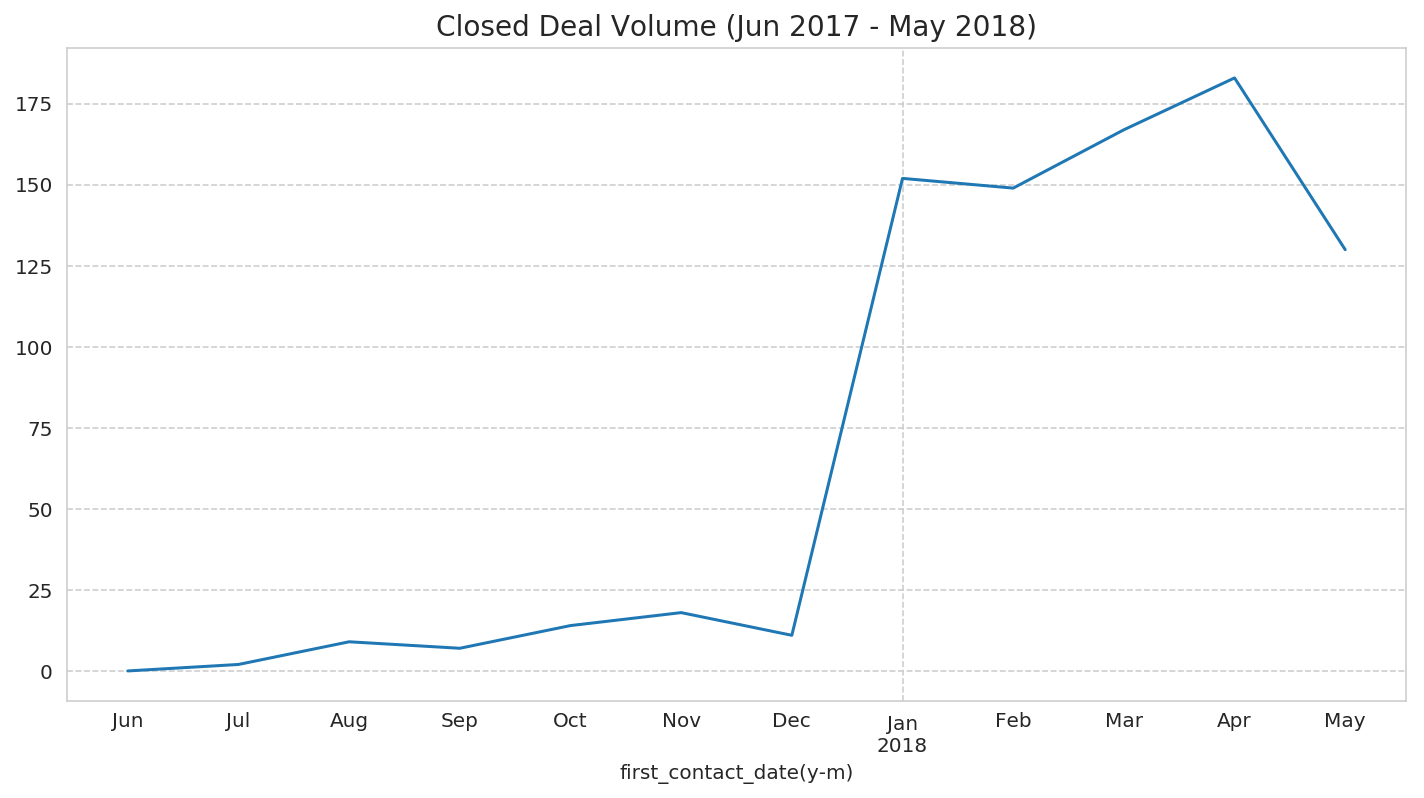

In [13]:
# Plot the monthly volume of closed deals
monthly_cd.plot.line(figsize=(12, 6))
plt.title('Closed Deal Volume (Jun 2017 - May 2018)', fontsize=14);

Likewise, monthly volume of closed deals sharply increased after 2018.

### Conversion Rate
Conversion rate means the percentage of MQLs who finally signed up for sellers (closed deals). 

In [14]:
# Calculate monthly conversion rate
monthly_conversion = mql_cd.groupby(by='first_contact_date(y-m)')['seller_id(bool)'].agg(['count', 'sum'])

monthly_conversion['conversion_rate(%)'] = ((monthly_conversion['sum'] / monthly_conversion['count']) * 100).round(1)
monthly_conversion.T

first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
count,4.0,239.0,386.0,312.0,416.0,445.0,200.0,1141.0,1028.0,1174.0,1352.0,1303.0
sum,0.0,2.0,9.0,7.0,14.0,18.0,11.0,152.0,149.0,167.0,183.0,130.0
conversion_rate(%),0.0,0.8,2.3,2.2,3.4,4.0,5.5,13.3,14.5,14.2,13.5,10.0


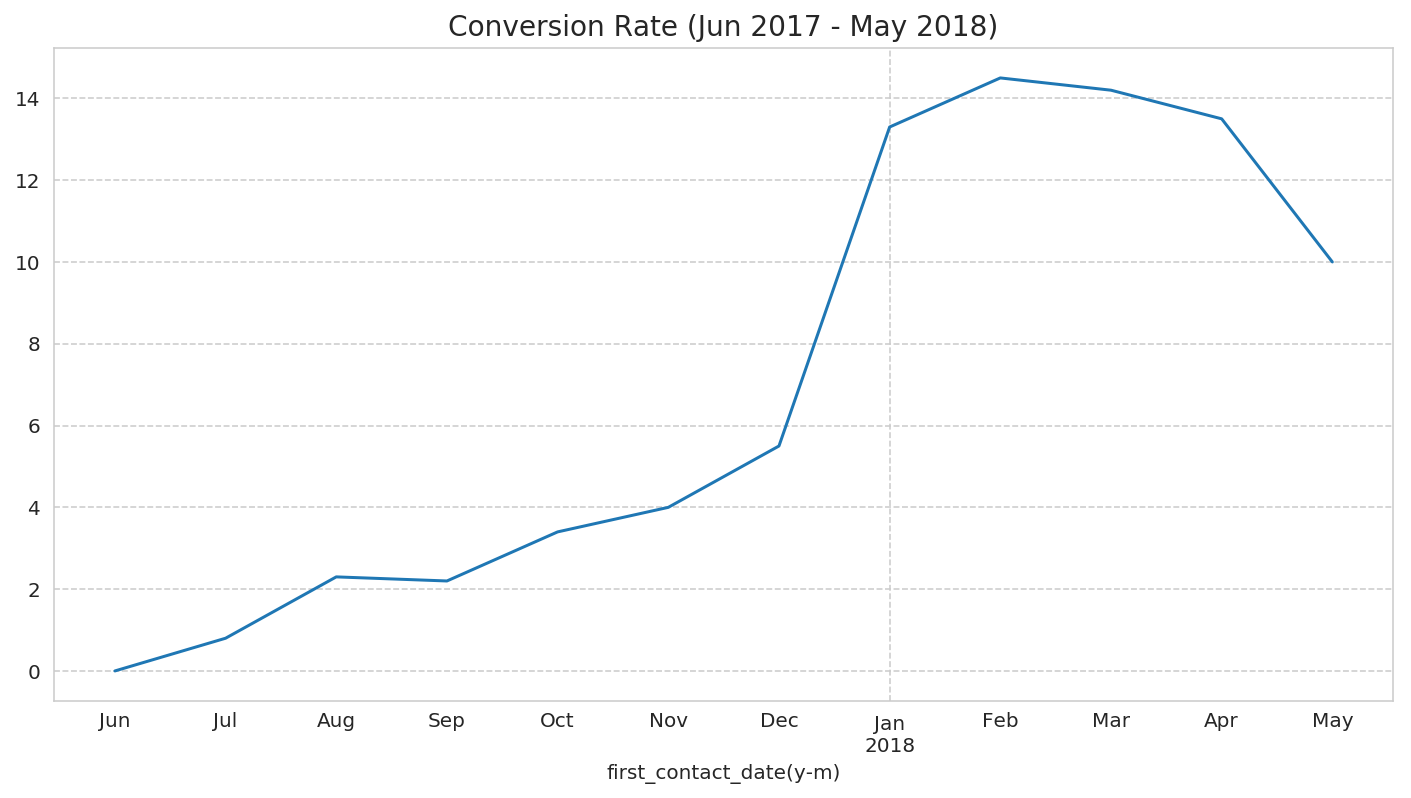

In [15]:
# Plot the monthly conversion rate
monthly_conversion['conversion_rate(%)'].plot.line(figsize=(12, 6))
plt.title('Conversion Rate (Jun 2017 - May 2018)', fontsize=14);

Conversion rate also increased with volume.

### Sales Length
Sales length means period from first contact to signing up for seller. 

In [16]:
# Calculate sales length in days
mql_cd['sales_length(day)'] = np.ceil((mql_cd['won_date'] - mql_cd['first_contact_date'])
                                      .dt.total_seconds()
                                      / (60*60*24))

print(mql_cd.shape)
mql_cd[['first_contact_date', 'won_date', 'sales_length(day)']].head()

(8000, 20)


,first_contact_date,won_date,sales_length(day)
0,2018-02-01,NaT,NaN
1,2017-10-20,NaT,NaN
2,2018-03-22,NaT,NaN
3,2018-01-22,NaT,NaN
4,2018-02-21,2018-02-26 19:58:54,6.0


In [17]:
# Separate sales length for each year
closed_deal = (mql_cd['seller_id'].notna())
lead_2017 = (mql_cd['first_contact_date'].dt.year.astype('str') == '2017')
lead_2018 = (mql_cd['first_contact_date'].dt.year.astype('str') == '2018')

sales_length_2017 = mql_cd[closed_deal & lead_2017]['sales_length(day)']
sales_length_2018 = mql_cd[closed_deal & lead_2018]['sales_length(day)']

sales_length_2017.head(3), sales_length_2018.head(3)

(67     268.0
 110    189.0
 239     55.0
 Name: sales_length(day), dtype: float64, 4      6.0
 12    35.0
 14    64.0
 Name: sales_length(day), dtype: float64)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


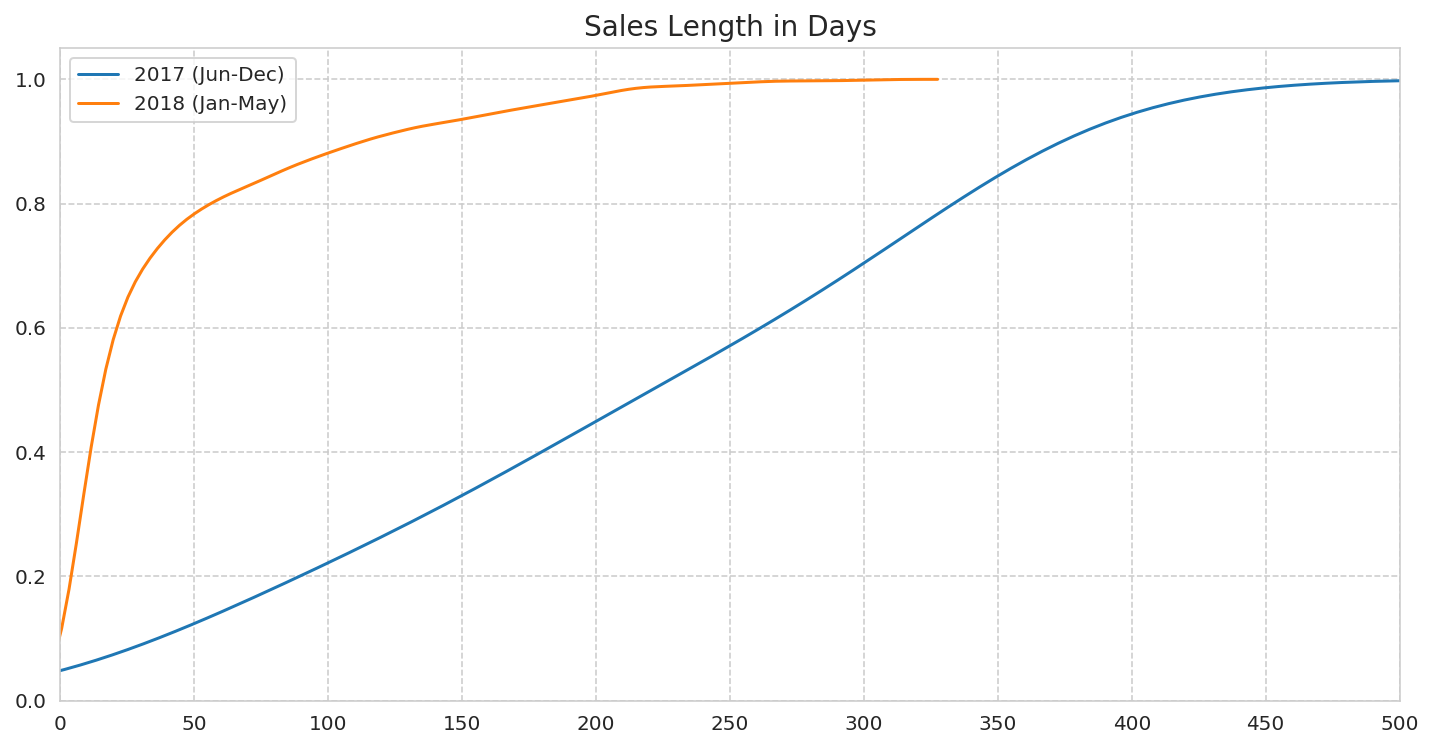

In [18]:
# Plot the sales length of each year
figure, ax = plt.subplots(figsize=(12,6))

sns.kdeplot(sales_length_2017,
            cumulative=True,
            label='2017 (Jun-Dec)',
            ax=ax)
sns.kdeplot(sales_length_2018,
            cumulative=True,
            label='2018 (Jan-May)',
            ax=ax)

ax.set_title('Sales Length in Days', fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xlim(0,500);

Sales length was dramatically shortened as well. While 13.1% of deals were closed within 50 days in 2017, 78.9% was closed in 2018. In a nutshell, both conversion rate and sales length were improved in 2018 against 2017. 

### Digging into Closed Deal
Before move on to the next subject, I will explore closed deals in more depth to see whether there is room for improvement in sales process. Specifically I'm looking into three dimensions of closed deals(__'lead type', 'business segment', 'business type'__) with __'lead behaviour profile'__ as an axis.

#### Characteristics of Closed Deal

In [19]:
# Bring 'closed deals' data
cd_profile = cd[cd['lead_behaviour_profile'].notna()].copy()

print(cd_profile.shape)
cd_profile['lead_behaviour_profile'].value_counts()

(665, 14)


cat            407
eagle          123
wolf            95
shark           24
cat, wolf        8
eagle, wolf      3
eagle, cat       3
shark, wolf      1
shark, cat       1
Name: lead_behaviour_profile, dtype: int64

In [20]:
# Combine four types of mixed profiles(2.4%) into 'others'
profile_list = ['cat', 'eagle', 'wolf', 'shark']

cd_profile['lead_behaviour_profile(upd)'] = cd_profile.lead_behaviour_profile \
                                                      .map(lambda profile: profile
                                                           if profile in profile_list
                                                           else 'others')

print(cd_profile.shape)
cd_profile['lead_behaviour_profile(upd)'].value_counts()

(665, 15)


cat       407
eagle     123
wolf       95
shark      24
others     16
Name: lead_behaviour_profile(upd), dtype: int64

In [21]:
# Create 'profile - lead type' table
cols = cd_profile['lead_type'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_leadType = pd.pivot_table(cd_profile,
                                  index='lead_behaviour_profile(upd)',
                                  columns='lead_type',
                                  values='seller_id',
                                  aggfunc='count',
                                  fill_value=0)

profile_leadType = profile_leadType.reindex(index)[cols]
profile_leadType

lead_type,online_medium,online_big,industry,offline,online_small,online_beginner,online_top,other
cat,157,72,49,49,37,31,8,2
eagle,46,11,25,22,12,6,1,0
wolf,45,16,14,9,6,5,0,0
shark,9,4,4,5,1,0,1,0
others,8,3,2,1,1,0,0,1


In [22]:
# Create 'profile - business type' table
cols = cd_profile['business_type'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_businessType = pd.pivot_table(cd_profile,
                                      index='lead_behaviour_profile(upd)',
                                      columns='business_type',
                                      values='seller_id',
                                      aggfunc='count',
                                      fill_value=0)

profile_businessType = profile_businessType.reindex(index)[cols]
profile_businessType

business_type,reseller,manufacturer,other
cat,284,116,2
eagle,83,37,0
wolf,69,26,0
shark,16,7,0
others,13,2,1


In [23]:
# Create 'profile - business segment' table
cols = cd_profile['business_segment'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_segment = pd.pivot_table(cd_profile,
                                 index='lead_behaviour_profile(upd)',
                                 columns='business_segment',
                                 values='seller_id',
                                 aggfunc='count',
                                 fill_value=0)

profile_segment = profile_segment.reindex(index)[cols]
profile_segment

business_segment,home_decor,health_beauty,car_accessories,construction_tools_house_garden,household_utilities,audio_video_electronics,computers,pet,sports_leisure,food_supplement,bags_backpacks,food_drink,bed_bath_table,toys,fashion_accessories,handcrafted,phone_mobile,home_office_furniture,stationery,small_appliances,baby,music_instruments,books,watches,home_appliances,jewerly,gifts,other,party,games_consoles,perfume,air_conditioning,religious
cat,51,43,41,35,32,38,16,15,17,13,9,8,11,9,8,7,6,6,8,6,6,2,2,2,3,3,3,2,2,1,1,0,1
eagle,11,13,12,11,12,8,3,4,4,5,4,4,2,3,4,3,4,4,1,1,2,2,0,2,1,0,1,0,1,0,1,0,0
wolf,14,8,9,7,9,8,5,4,1,2,4,4,2,1,1,1,0,1,1,1,1,2,4,1,2,1,0,0,0,0,0,1,0
shark,4,5,2,4,3,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
others,0,1,2,0,1,0,2,0,0,0,0,1,1,2,0,0,0,0,1,2,0,0,0,1,0,0,0,1,0,1,0,0,0


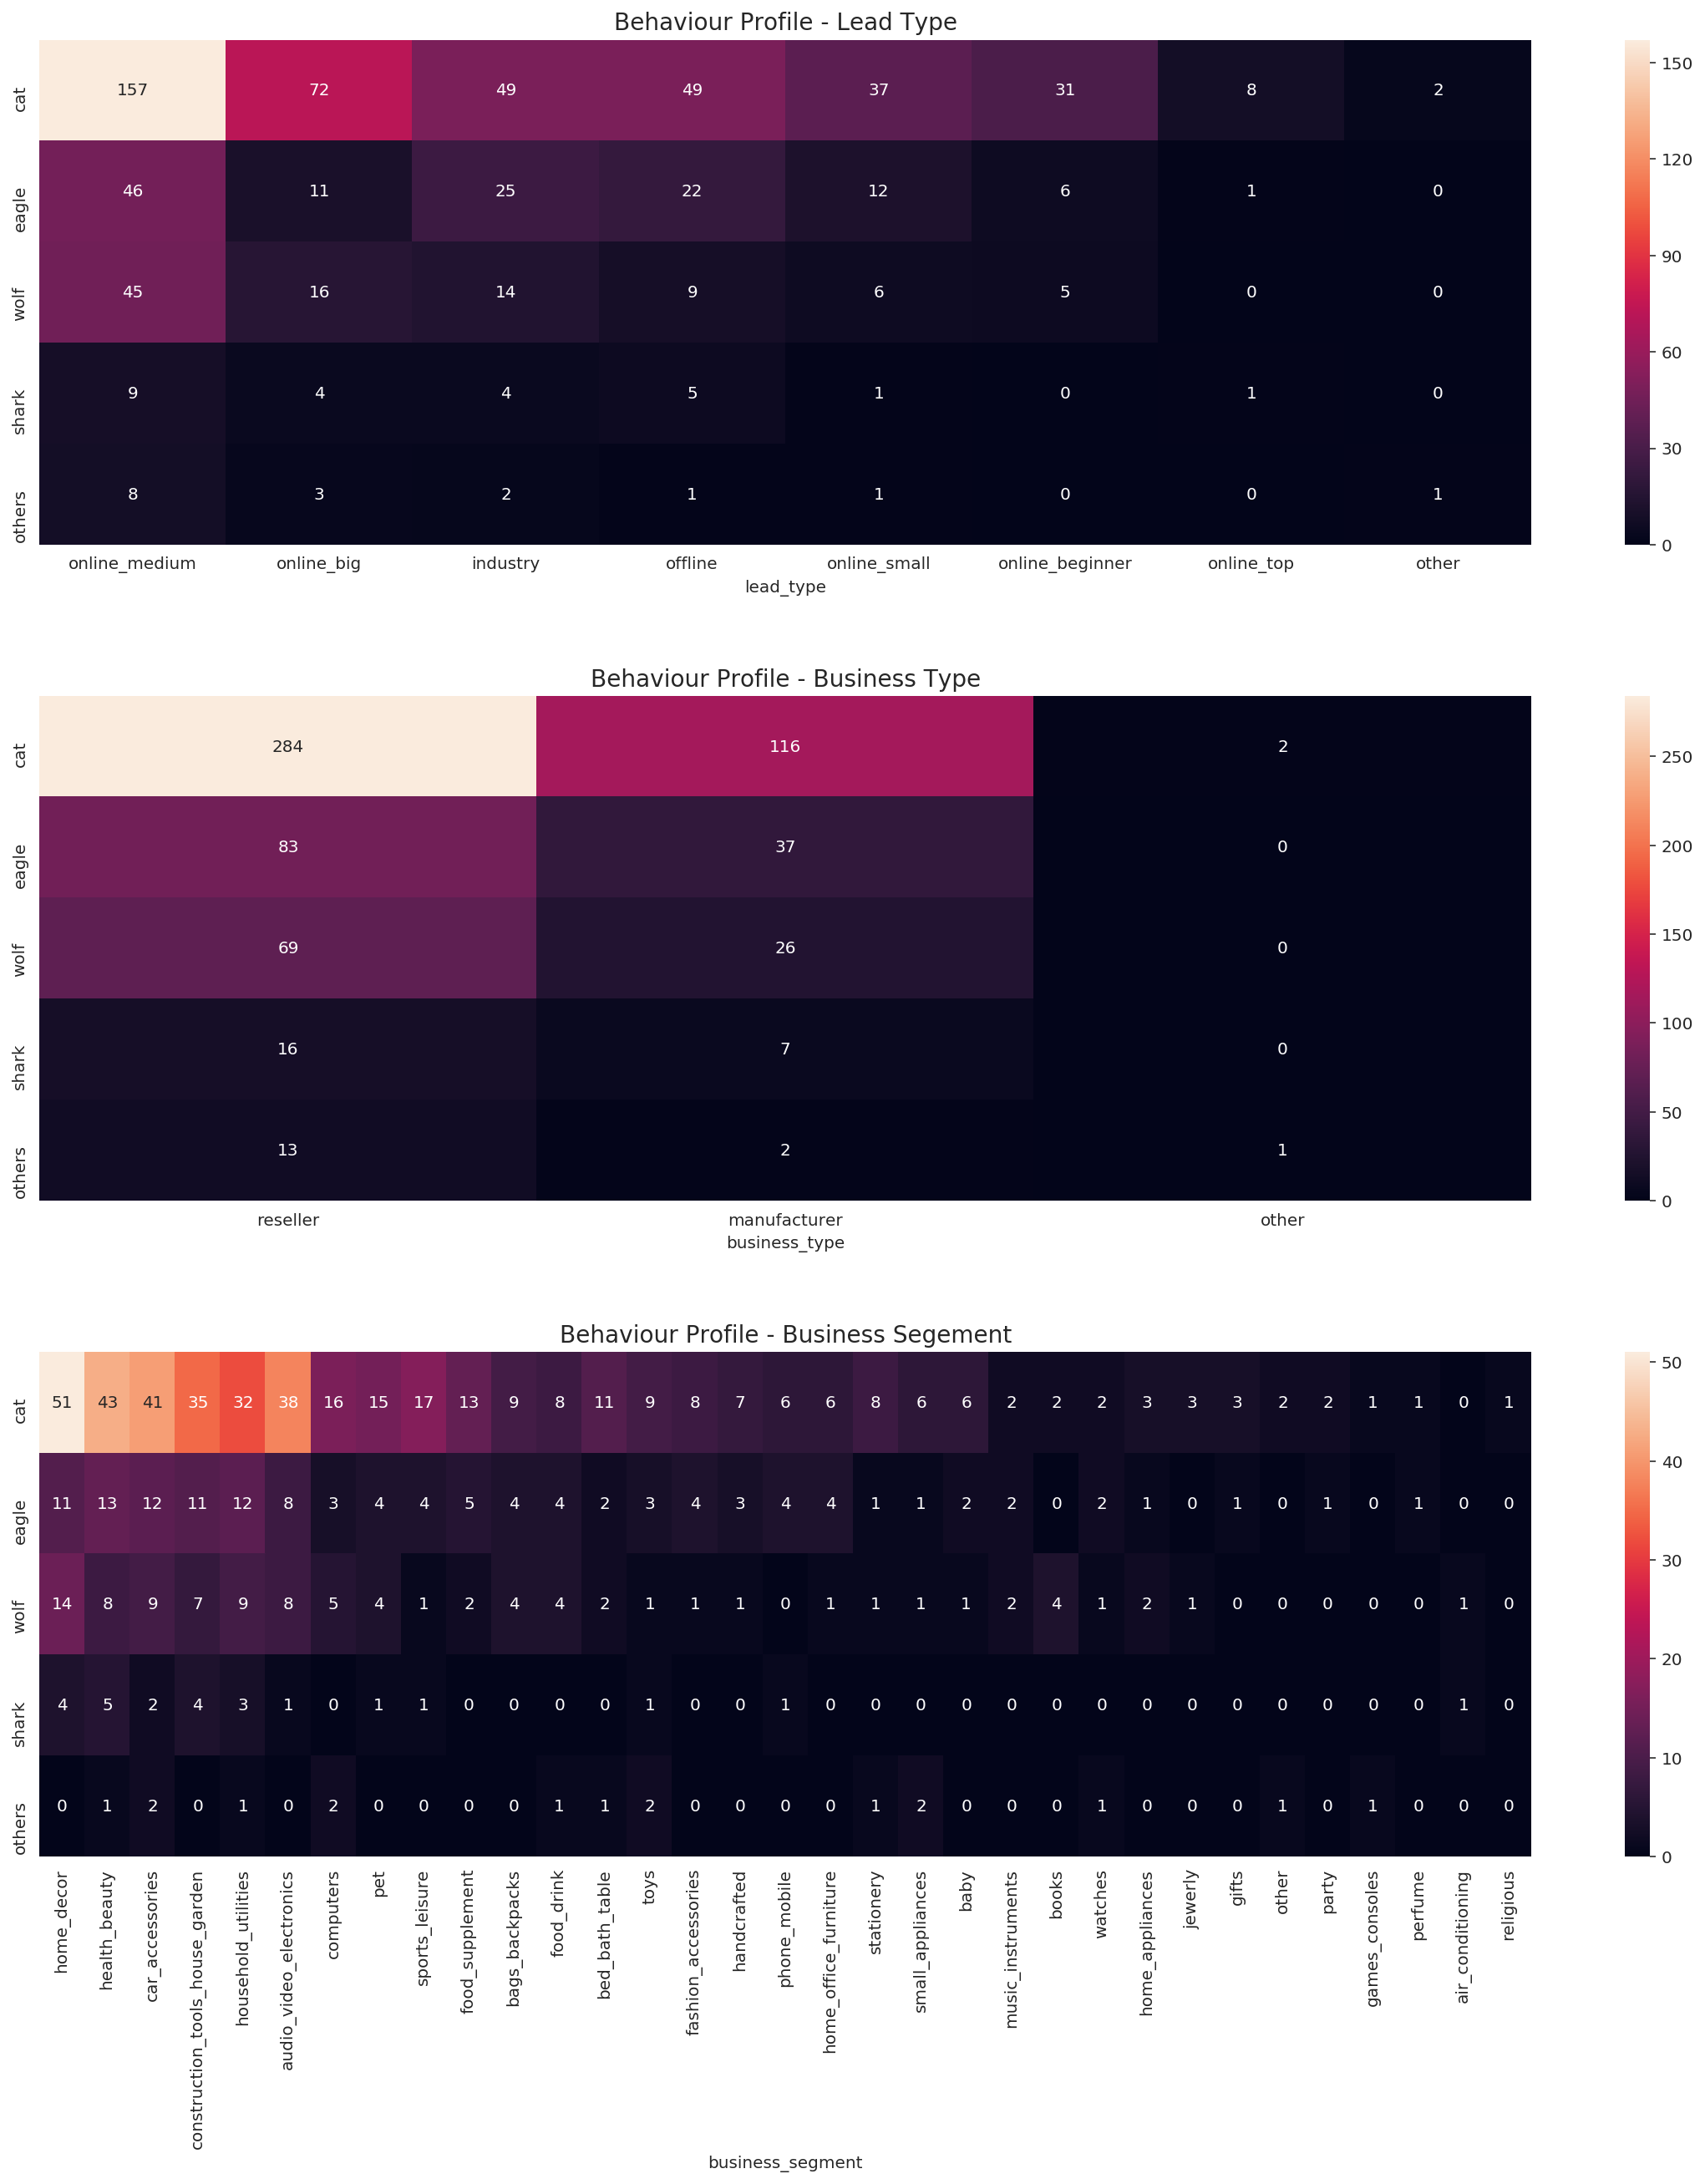

In [24]:
# Plot the above three tables
figure, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,20))
figure.subplots_adjust(hspace=0.3)

sns.heatmap(profile_leadType,
            annot=True,
            fmt='g',
            ax=ax1)
sns.heatmap(profile_businessType,
            annot=True,
            fmt='g',
            ax=ax2)
sns.heatmap(profile_segment,
            annot=True,
            fmt='g',
            ax=ax3)

ax1.set_title('Behaviour Profile - Lead Type', fontsize=14)
ax2.set_title('Behaviour Profile - Business Type', fontsize=14)
ax3.set_title('Behaviour Profile - Business Segement', fontsize=14);

'lead_behaviour_profile' is related to DISC personality test. Each type has the meaning as follows.  
_\* Source: [DISC Profile](https://www.discprofile.com/what-is-disc/overview/)_

Behaviour_profile | DISC_profile | Description
------------------- | ------------- | ------------
Cat | Steadiness | Person places emphasis on cooperation, sincerity, dependability
Eagle | Influence | Person places emphasis on influencing or persuading others, openness, relationships
Wolf | Conscientiousness | Person places emphasis on quality and accuracy, expertise, competency
Shark | Dominance | Person places emphasis on accomplishing results, the bottom line, confidence
 
+ Closed deals are won in order of cat, eagle, wolf and shark based on descending volume in all three dimensions.
+ In consideration of business context, it might make sense that conversion rate of wolf (accuracy-focused) or shark (result-focused) was lower than cat (cooperation-focused) or eagle (relationship-focused).

If so, sales performance could be improved by matching SDRs/SRs with MQLs properly.

#### SDR/SR Performance by Behaviour Profile

In [25]:
# Create 'profile-SDR' table
cols = cd_profile['sdr_id'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_sdr = pd.pivot_table(cd_profile,
                             index='lead_behaviour_profile(upd)',
                             columns='sdr_id',
                             values='seller_id',
                             aggfunc='count',
                             fill_value=0)

profile_sdr = profile_sdr.reindex(index)[cols] # Sort SDR in descending order of volume 
profile_sdr

sdr_id,4b339f9567d060bcea4f5136b9f5949e,9d12ef1a7eca3ec58c545c678af7869c,a8387c01a09e99ce014107505b92388c,9e4d1098a3b0f5da39b0bc48f9876645,068066e24f0c643eb1d089c7dd20cd73,370c9f455f93a9a96cbe9bea48e70033,f42a2bd194f7802ab052a815c8de65b7,09285259593c61296eef10c734121d5b,34d40cdaf94010a1d05b0d6212f9e909,56bf83c4bb35763a51c2baab501b4c67,b90f87164b5f8c2cfa5c8572834dbe3f,0a0fb2b07d841f84fb6714e35c723075,de63de0d10a6012430098db33c679b0b,e7dff61b78bebffa71678e126ce669ad,45749fb708130f78d0db07d8d80f030b,fdb16d3cbbeb5798f2f66c4096be026d,9749123c950bf8363ace42cb1c2d0815,33dd30594303eb0ebe12a556d612c437,2b63542749aa9caf15f21816da1db341,323cff2ceea1814239bc2c7e614d260d,6aa3b86a83d784b05f0e37e26b20860d,0cdad77786224a7cefea567b8c75c3c1,b34f6eba10f46bf9a657a01c108a8284,084b6fbb10729ed4da8c3d3f5a3ae7c9,e4a6222cdb5b34375400904f03d8e6a5,5b7ce8c2b0fe4c2f52a0763046914ef4,282f16e20d50cb18d05182e80f6b9dd6,19f3cd308f1455b3fa09a282e0d496f4,b1b3ec93fc27a19fdb1c1b1fc997776a
cat,52,35,50,37,43,26,23,25,30,24,15,10,8,4,3,5,3,3,2,2,1,2,1,1,0,1,0,1,0
eagle,9,22,4,10,3,14,7,8,8,16,4,12,2,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
wolf,42,6,3,3,3,7,7,7,1,0,3,1,2,2,3,1,1,0,1,1,0,0,0,0,0,0,1,0,0
shark,8,0,0,3,2,2,1,2,2,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
others,1,1,0,0,0,1,4,0,0,0,2,0,0,2,2,0,1,0,0,0,0,0,0,0,1,0,0,0,1


In [26]:
# Create 'profile-SR' table
cols = cd_profile['sr_id'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_sr = pd.pivot_table(cd_profile,
                            index='lead_behaviour_profile(upd)',
                            columns='sr_id',
                            values='seller_id',
                            aggfunc='count',
                            fill_value=0)

profile_sr = profile_sr.reindex(index)[cols] # Sort SR in descending order of volume
profile_sr

sr_id,4ef15afb4b2723d8f3d81e51ec7afefe,85fc447d336637ba1df43e793199fbc8,6565aa9ce3178a5caf6171827af3a9ba,d3d1e91a157ea7f90548eef82f1955e3,de63de0d10a6012430098db33c679b0b,2695de1affa7750089c0455f8ce27021,495d4e95a8cf8bbf8b432b612a2aa328,fbf4aef3f6915dc0c3c97d6812522f6a,c638112b43f1d1b86dcabb0da720c901,068066e24f0c643eb1d089c7dd20cd73,a8387c01a09e99ce014107505b92388c,060c0a26f19f4d66b42e0d8796688490,9e4d1098a3b0f5da39b0bc48f9876645,56bf83c4bb35763a51c2baab501b4c67,9ae085775a198122c5586fa830ff7f2b,34d40cdaf94010a1d05b0d6212f9e909,4b339f9567d060bcea4f5136b9f5949e,9749123c950bf8363ace42cb1c2d0815,9d12ef1a7eca3ec58c545c678af7869c,6aa3b86a83d784b05f0e37e26b20860d,0a0fb2b07d841f84fb6714e35c723075,b90f87164b5f8c2cfa5c8572834dbe3f
cat,58,41,31,28,37,34,30,30,17,11,14,15,16,17,12,3,7,2,3,0,1,0
eagle,23,7,13,12,7,9,6,9,5,7,6,2,6,2,4,4,0,0,0,0,0,1
wolf,12,11,11,11,5,6,7,2,3,4,3,6,0,2,5,0,2,4,1,0,0,0
shark,0,4,0,2,4,2,2,2,0,1,0,1,2,2,1,0,0,1,0,0,0,0
others,2,0,0,1,0,2,1,0,0,2,1,0,0,0,1,3,0,0,2,1,0,0


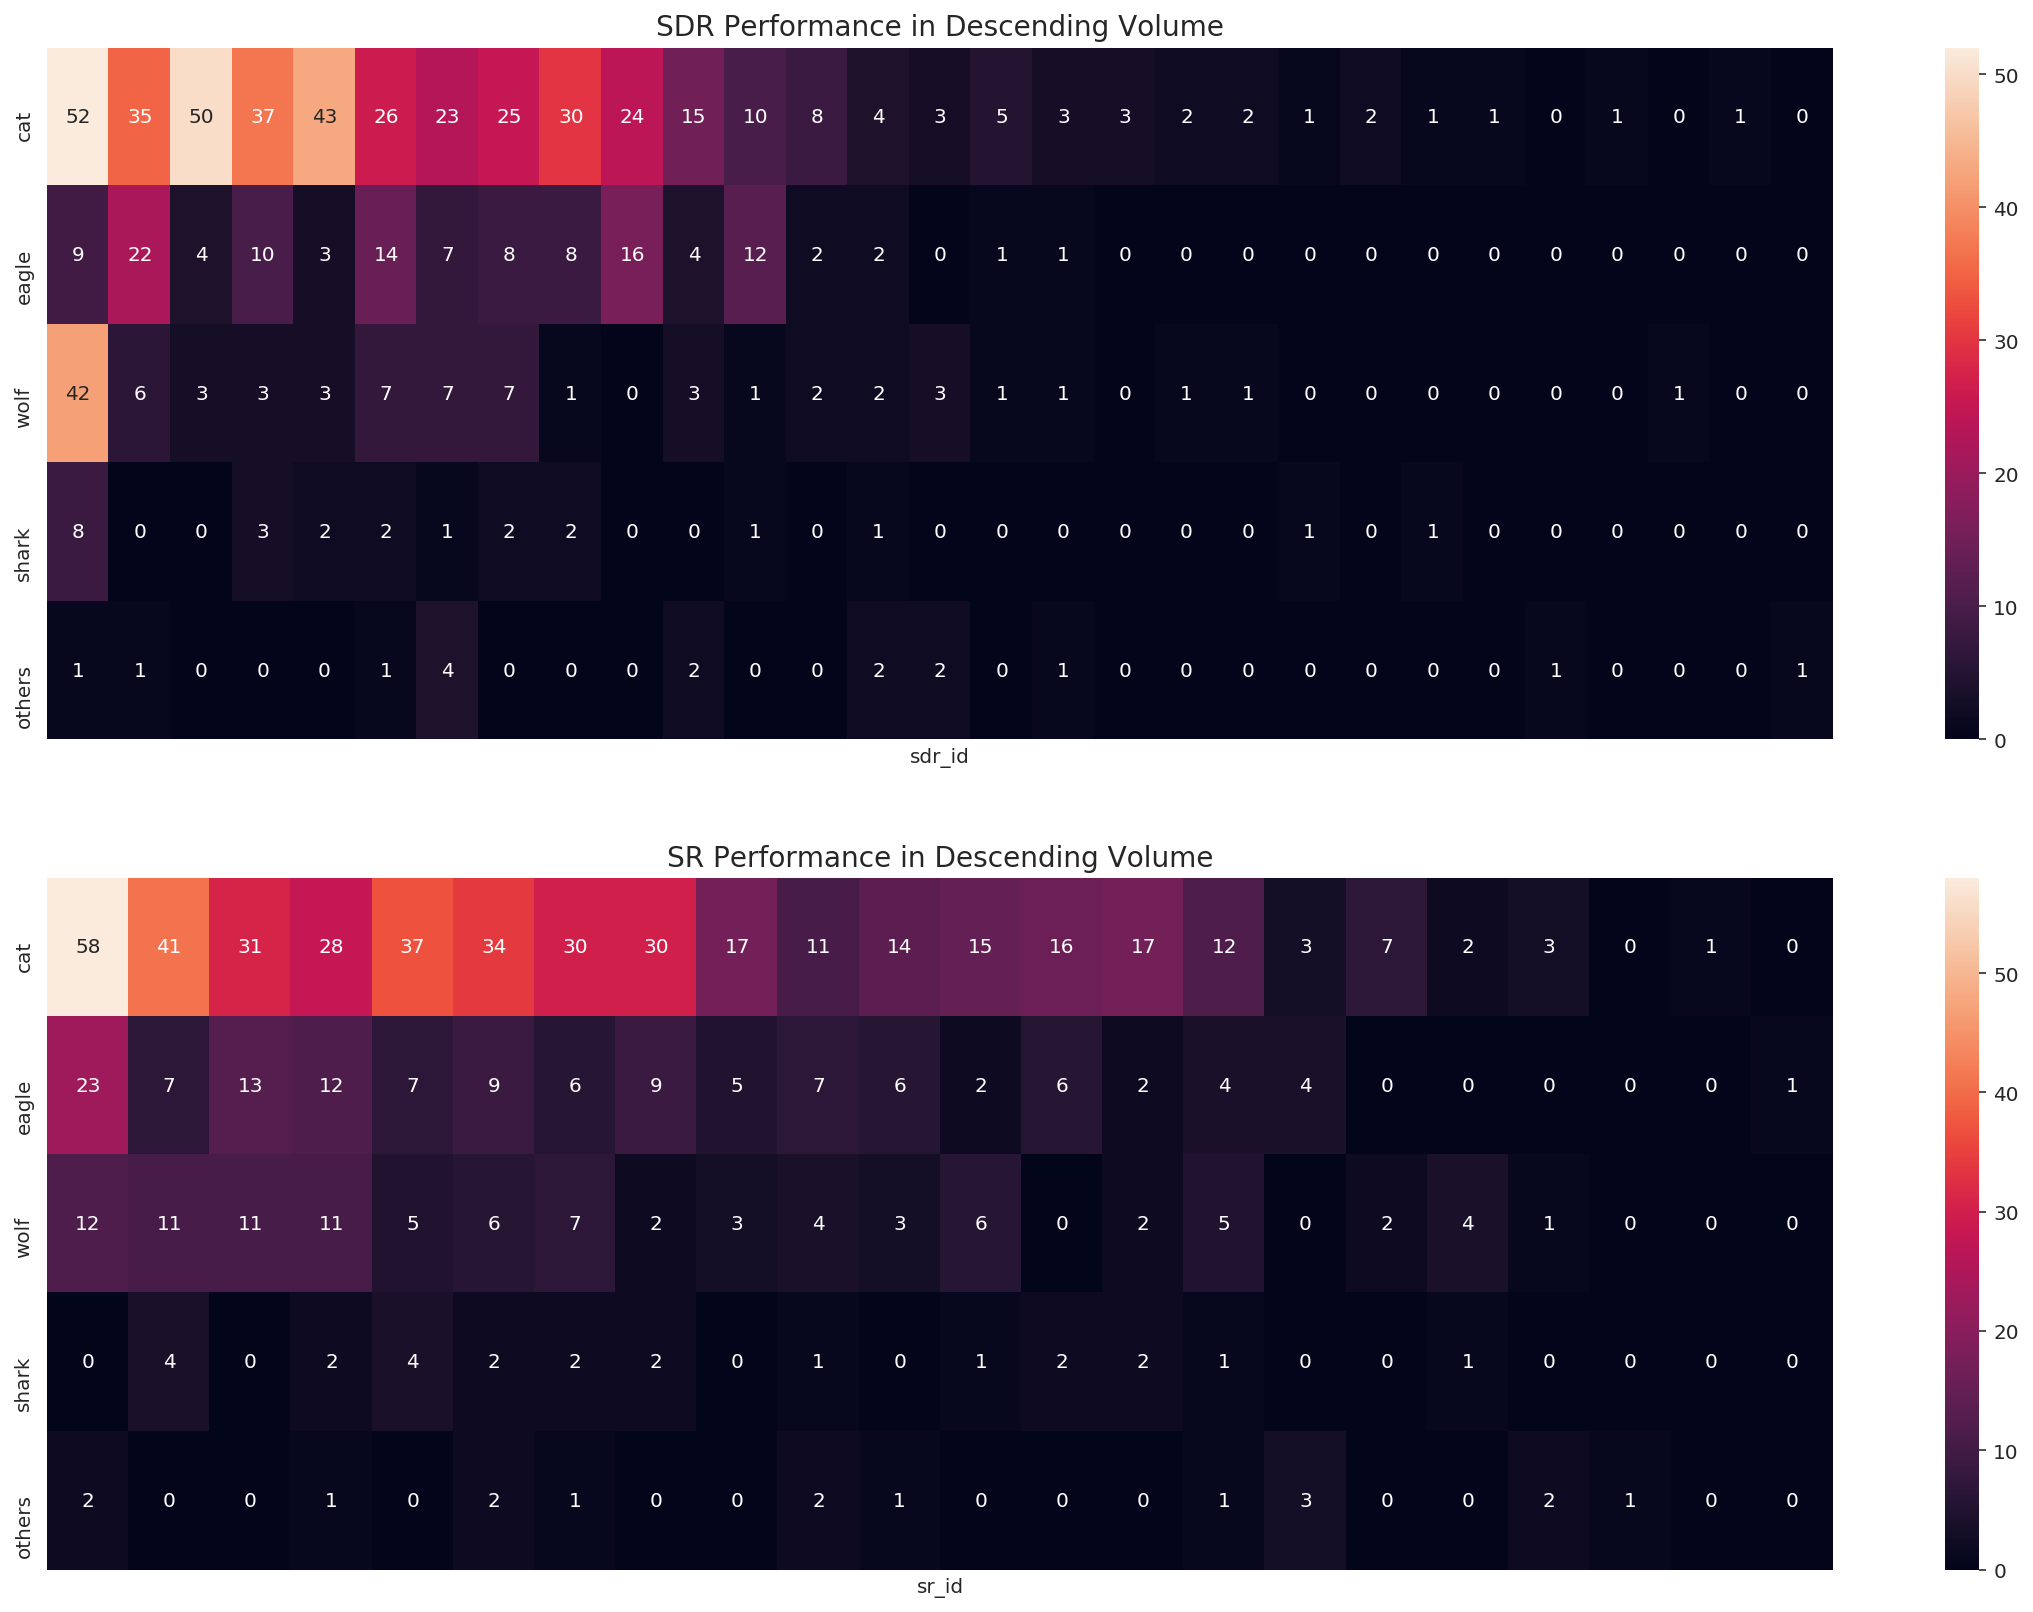

In [27]:
# Plot the two tables
figure, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,14))
figure.subplots_adjust(hspace=0.2)

sns.heatmap(profile_sdr,
            annot=True,
            fmt='g',
            ax=ax1)
sns.heatmap(profile_sr,
            annot=True,
            fmt='g',
            ax=ax2)

ax1.set_title('SDR Performance in Descending Volume', fontsize=14)
ax2.set_title('SR Performance in Descending Volume', fontsize=14)
ax1.set_xticks([])
ax2.set_xticks([]);

1. SDR
 + 1st and 3rd SDRs are eminent in handling cat.
 + 2nd and 10th SDRs are specialized in eagle.
 + 1st SDR is also unparalleled in dealing with wolf.
 + As to shark 1st SDR is better than the others, but not enough to claim to be an expert.
 + __SDR is the first contact point of MQL so they do not know the lead's behaviour profile yet. Therefore sharing top performers' expertise in cat, eagle or wolf can enhance team performance.__
 + __In regard to shark, external resources may be helpful in building capability.__

2. SR
  + 1st SR has matchless skills in managing both cat and eagle.
  + SRs on the first four places are good at handling wolf, but not as much as their highest performing fields.
  + 2nd and 5th are the best performers in regard to shark, but hard to say 'proficient'.
  + __Eagle can be assigned to 2nd SR. Further, spreading knowledge among the team can improve team performance.__
  + __Like SDR, external knowledge sources can be a way to boost performance.__

## 3. Closed Deal Performance Overview
---
In this part I will see the total revenue from closed deals after signing in and drill down the top revenue-generating segment.

In [28]:
# Load datasets
cd = pd.read_csv('../input/marketing-funnel-olist/olist_closed_deals_dataset.csv')
order_items = pd.read_csv('../input/brazilian-ecommerce/olist_order_items_dataset.csv')
orders = pd.read_csv('../input/brazilian-ecommerce/olist_orders_dataset.csv',
                     parse_dates=['order_purchase_timestamp'])
products = pd.read_csv('../input/brazilian-ecommerce/olist_products_dataset.csv')
product_translation = pd.read_csv('../input/brazilian-ecommerce/product_category_name_translation.csv')

In [29]:
print(cd.shape)
print(order_items.shape)
print(orders.shape)
print(products.shape)
print(product_translation.shape)

(842, 14)
(112650, 7)
(99441, 8)
(32951, 9)
(71, 2)


In [30]:
# Merge all of the data
data = pd.merge(cd,order_items,
                how='inner', on='seller_id')
data = pd.merge(data, orders,
                how='inner', on='order_id')
data = pd.merge(data, products,
                how='inner', on='product_id')
data = pd.merge(data, product_translation,
                how='left', on='product_category_name') # There are some data without english names
data.shape

(5044, 36)

In [31]:
# Sort out orders not devliered to customers
data = data[data['order_status'] == 'delivered']

# Add a 'year-month' column
data['order_purchase_timestamp(y-m)'] = data['order_purchase_timestamp'].dt.to_period('M')

print(data.shape)
data.head(3)

(4984, 37)


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_purchase_timestamp(y-m)
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,1efcc6ba75b519535a510c53153a9256,1,e94df75b2e9a8b056be0c144a731f55c,2018-06-26 22:20:21,94.2,18.76,27a878219114302047d41366ffeeba1e,delivered,2018-06-20 21:40:18,2018-06-20 22:20:21,2018-06-22 15:23:00,2018-06-26 20:06:25,2018-07-17 00:00:00,pet_shop,56.0,1538.0,2.0,625.0,23.0,17.0,19.0,pet_shop,2018-06
1,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,d8d281c1a1398a1e835fdc4adfb81e2a,1,9e0873e9ac04b12f282b81af5daebd2e,2018-07-30 09:31:49,664.0,38.41,14c1e4101ca2dc7dbf876d9c9e6b11a6,delivered,2018-07-23 20:50:50,2018-07-24 10:31:11,2018-07-25 15:09:00,2018-07-27 18:27:42,2018-08-07 00:00:00,ferramentas_jardim,25.0,432.0,1.0,2825.0,29.0,29.0,29.0,garden_tools,2018-07
2,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,e5858127da61f07285827883e605254b,1,9bb2d066e4b33b624cbdfec7d50b3dcb,2018-06-27 16:00:04,99.8,15.00,bcd15e6f5399f2899de4482cf6783dae,delivered,2018-06-21 15:42:55,2018-06-21 16:00:04,2018-06-22 15:23:00,2018-06-25 14:28:27,2018-07-13 00:00:00,pet_shop,53.0,1494.0,2.0,900.0,26.0,19.0,23.0,pet_shop,2018-06


### Monthly Revenues by Business Segment
_\* Revenue is calculated by summing up price_

In [32]:
cols = data.groupby(by='business_segment') \
           .price \
           .sum() \
           .sort_values(ascending=False) \
           .index

monthly_segment_revenue = data.groupby(['order_purchase_timestamp(y-m)', 'business_segment']) \
                              .price \
                              .sum() \
                              .unstack(level=1, fill_value=0)

monthly_segment_revenue = monthly_segment_revenue[cols]
monthly_segment_revenue

business_segment,watches,health_beauty,household_utilities,audio_video_electronics,small_appliances,home_decor,pet,construction_tools_house_garden,car_accessories,home_appliances,sports_leisure,bed_bath_table,baby,bags_backpacks,computers,food_supplement,home_office_furniture,stationery,fashion_accessories,books,music_instruments,toys,phone_mobile,food_drink,air_conditioning,gifts,handcrafted,games_consoles,party
order_purchase_timestamp(y-m),,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,89.90,0.00,0.00,0.00,70.00,0.00,634.40,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00
2018-02,5935.46,28.00,443.60,20.00,140.00,1042.50,211.96,677.56,178.90,0.00,0.00,262.40,148.98,45.50,0.00,370.80,0.00,76.00,0.00,0.00,1447.90,234.69,0.00,0.00,0.0,0.00,0.0,0.0,0.00
2018-03,27439.45,567.50,2233.49,2842.87,12620.00,531.50,377.86,1154.44,347.00,145.97,362.10,679.59,0.00,0.00,34.50,2397.74,0.00,820.40,0.00,19.90,179.90,238.10,642.00,14.90,0.0,0.00,0.0,0.0,0.00
2018-04,21918.00,6793.63,5008.94,3074.49,12529.90,2857.34,4586.34,2611.66,4266.00,869.98,2162.48,2604.09,6113.15,720.37,599.50,2368.75,0.00,759.84,0.00,344.45,439.79,923.06,1189.90,223.50,0.0,189.00,0.0,0.0,0.00
2018-05,31286.81,17073.44,10153.85,9813.11,14447.50,6134.17,3316.38,6499.96,3451.86,435.00,2472.48,3330.90,364.78,2216.66,1425.91,1422.50,2736.57,422.80,676.70,3023.27,494.86,670.41,152.90,413.80,0.0,0.00,0.0,0.0,0.00
2018-06,11547.88,25298.46,10497.65,10067.49,3909.80,8414.03,6292.87,4591.75,5414.06,2494.49,2263.28,2133.39,4283.87,3183.85,840.48,1093.89,1020.83,2397.94,1016.90,1020.19,973.59,1116.54,1247.59,302.40,282.0,0.00,93.8,0.0,0.00
2018-07,7393.44,20035.20,11568.15,12017.70,1187.20,10980.97,9526.63,8485.62,6637.60,16278.83,4401.55,2335.46,1147.68,2295.48,1440.48,1305.07,2884.44,2171.40,5162.90,1554.74,1189.70,1153.53,449.70,1148.49,278.0,482.98,93.8,438.0,0.00
2018-08,10380.04,19128.11,11375.19,11587.78,2840.47,13848.82,16186.79,7986.08,9710.56,6016.90,3929.63,4012.80,2152.50,5471.95,7431.42,1335.30,3258.72,848.58,974.58,980.34,1113.90,1220.53,599.30,1599.84,2090.0,339.29,688.3,219.0,388.98


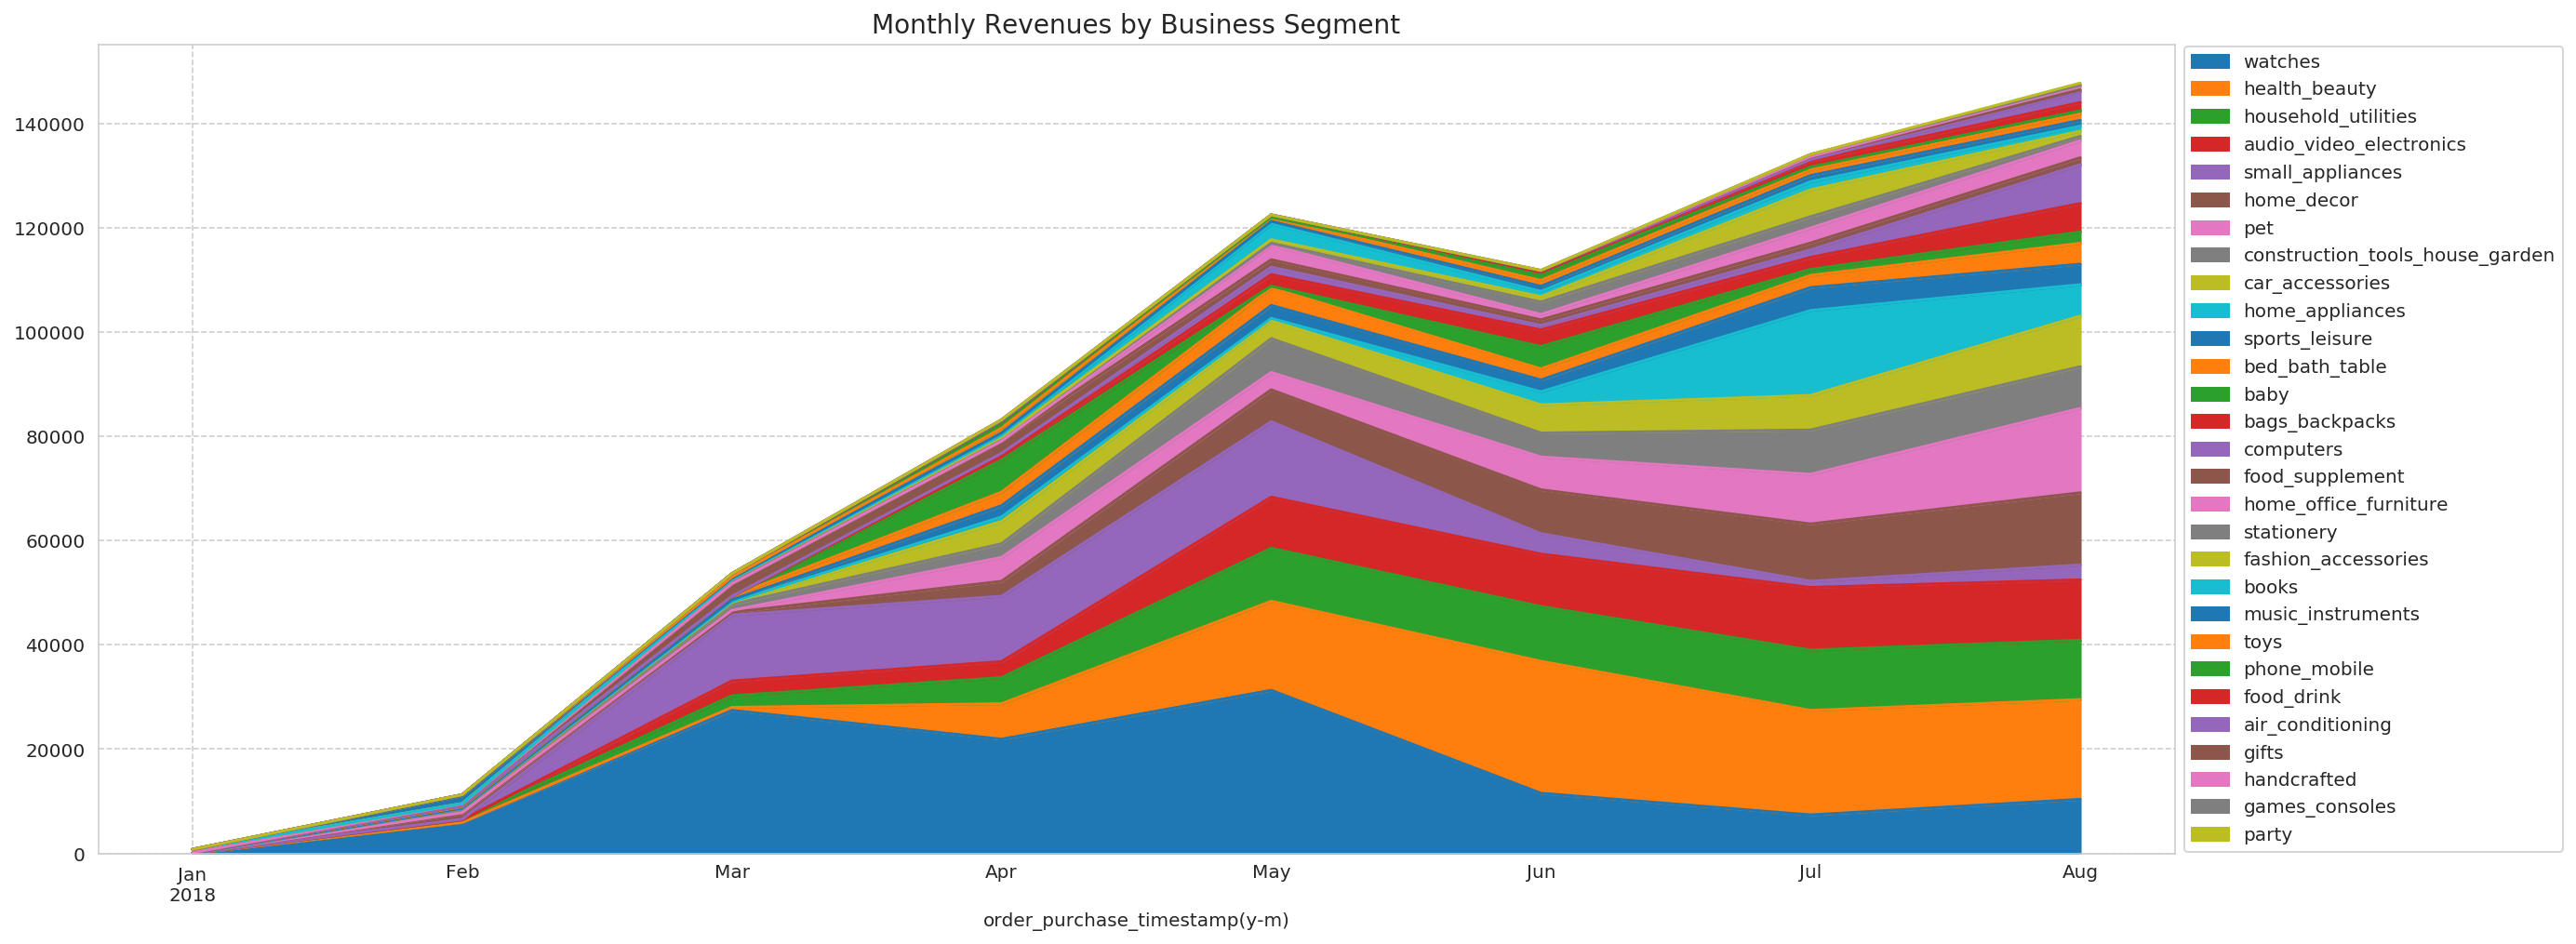

In [33]:
# Plot the monthly revenues by segment
monthly_segment_revenue.plot.area(figsize=(20,8))

plt.title('Monthly Revenues by Business Segment', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

+ Total revenues across 29 segments came in at 664,858 in the first eight months of 2018.
+ The biggest segment was 'watches', which generated 17.4% of total revenues (115,901).

Let's dive into the 'watches' segment to see what we can learn.

#### Watches Revenue by Product Category

In [34]:
# Create watches segment dataframe
watches = data[data.business_segment == 'watches']
watches.shape

(586, 37)

In [35]:
# Create monthly revenues by product category
cols = watches.groupby('product_category_name_english') \
              .price \
              .sum() \
              .sort_values(ascending=False) \
              .index

monthly_revenue_category = watches.groupby(['order_purchase_timestamp(y-m)', 'product_category_name_english']) \
                                  .price \
                                  .sum() \
                                  .unstack(level=1, fill_value=0)

monthly_revenue_category = monthly_revenue_category[cols]
monthly_revenue_category

product_category_name_english,watches_gifts,audio,electronics,sports_leisure,cool_stuff,market_place,perfumery
order_purchase_timestamp(y-m),,,,,,,
2018-02,5065.36,590.00,280.10,0.0,0.0,0.0,0.0
2018-03,19106.69,7547.76,240.00,545.0,0.0,0.0,0.0
2018-04,15588.14,5609.89,719.97,0.0,0.0,0.0,0.0
2018-05,29070.81,2216.00,0.00,0.0,0.0,0.0,0.0
2018-06,9727.88,1172.00,0.00,468.0,180.0,0.0,0.0
2018-07,5747.44,876.00,370.00,0.0,180.0,0.0,220.0
2018-08,8077.86,550.00,1464.58,0.0,0.0,287.6,0.0


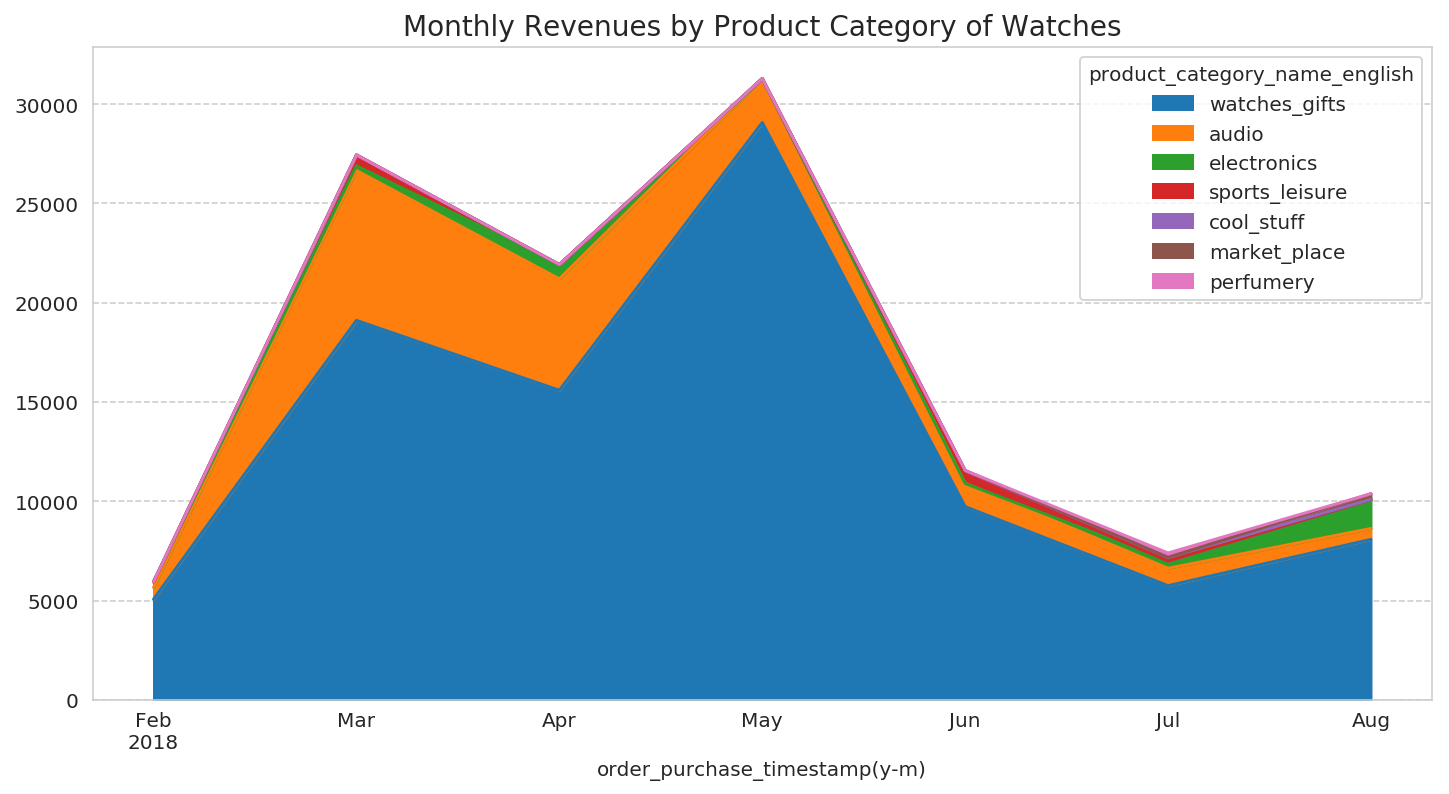

In [36]:
# Plot the monthly revenues by category
monthly_revenue_category.plot.area(figsize=(12,6))
plt.title('Monthly Revenues by Product Category of Watches', fontsize=14);

+ 'watches_gifts' category generated 79.7% of total revenue of segment.
+ 'watches_gifts' revenue soared in March and reached its peak in May. This category seems a seasonal item.
+ Except 'watches_gifts', product categories are irrelevant to watches segment.

#### Watches Revenue by Seller

In [37]:
# Create 'seller - product category' table
cols = watches.groupby('product_category_name_english') \
              .price \
              .sum() \
              .sort_values(ascending=False) \
              .index

watches_seller_revenue = watches.groupby(['seller_id', 'product_category_name_english']) \
                                .price \
                                .sum() \
                                .unstack(level=1, fill_value=0)

watches_seller_revenue = watches_seller_revenue[cols]
watches_seller_revenue['total'] = watches_seller_revenue.sum(axis=1)

watches_seller_revenue

product_category_name_english,watches_gifts,audio,electronics,sports_leisure,cool_stuff,market_place,perfumery,total
seller_id,,,,,,,,
7d13fca15225358621be4086e1eb0964,88919.28,18561.65,3074.65,1013.0,360.0,287.6,220.0,112436.18
bce6a5ecf98e99fd2a8868b15c51f04b,3464.90,0.00,0.00,0.0,0.0,0.0,0.0,3464.90


In [38]:
# Create 'category - seller' table
index = watches.groupby('product_category_name_english') \
               .price \
               .sum() \
               .sort_values() \
               .index

seller_category_revenue = watches.groupby(['seller_id', 'product_category_name_english']) \
                                 .price \
                                 .sum() \
                                 .unstack(level=0, fill_value=0) \
                                 
seller_category_revenue = seller_category_revenue.reindex(index)
seller_category_revenue

seller_id,7d13fca15225358621be4086e1eb0964,bce6a5ecf98e99fd2a8868b15c51f04b
product_category_name_english,,
perfumery,220.00,0.0
market_place,287.60,0.0
cool_stuff,360.00,0.0
sports_leisure,1013.00,0.0
electronics,3074.65,0.0
audio,18561.65,0.0
watches_gifts,88919.28,3464.9


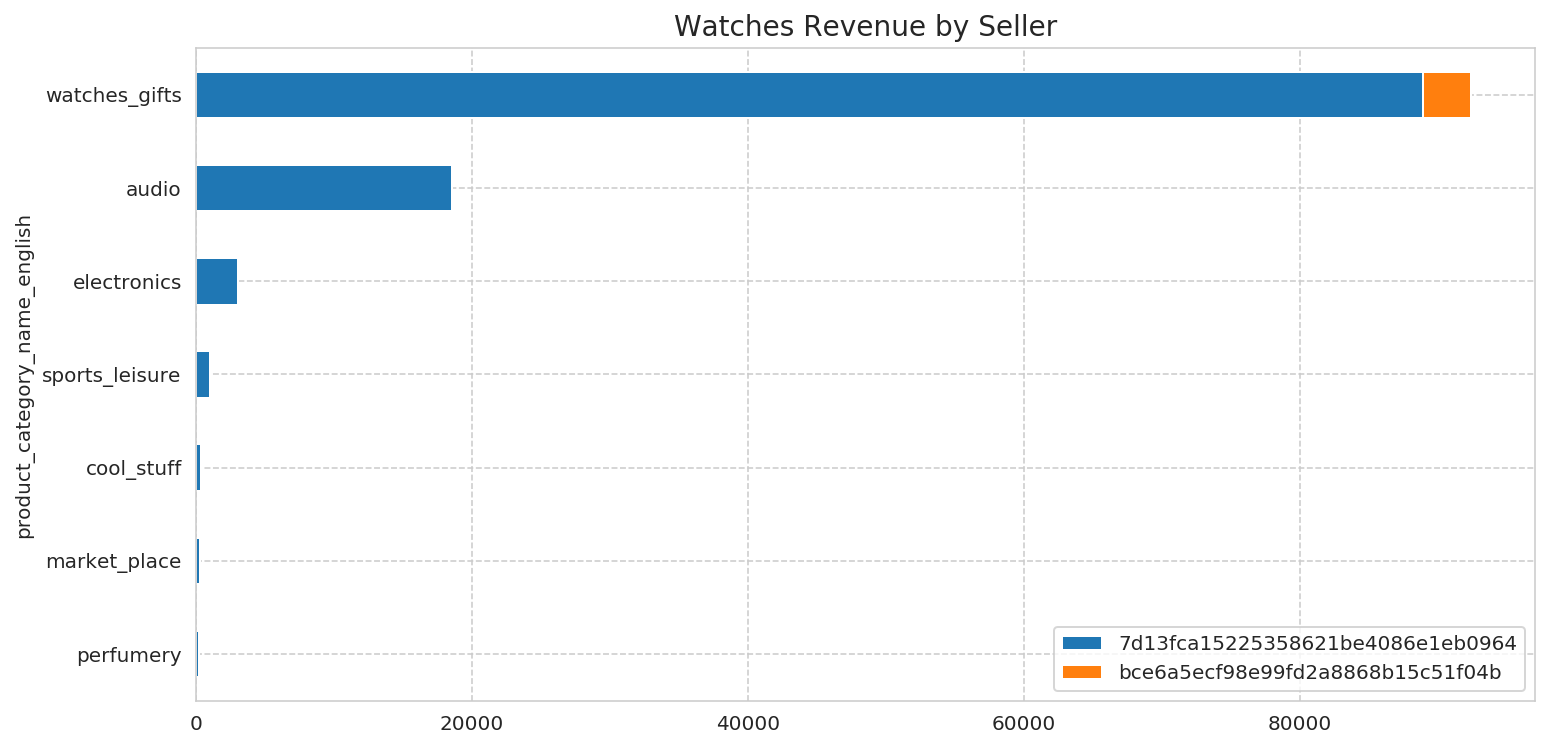

In [39]:
# Plot the above table
seller_category_revenue.plot.barh(stacked=True, figsize=(12,6))

plt.title('Watches Revenue by Seller', fontsize=14)
plt.legend(loc='lower right');

+ Though 'watches' segment is the largest part of revenue, it has only two sellers.
+ Furthermore, the leading seller generated 97.0% of segment revenue.

Let's uncover information about two sellers.

In [40]:
# Create seller info table
seller_ids = watches.groupby('seller_id').price.sum().index
fields = ['seller_id', 'won_date', 'business_segment', 'lead_type','business_type',]

data.loc[data['seller_id'].isin(seller_ids), fields] \
    .drop_duplicates(subset='seller_id', keep='first')

,seller_id,won_date,business_segment,lead_type,business_type
193,7d13fca15225358621be4086e1eb0964,2018-02-08 17:20:14,watches,online_big,reseller
420,bce6a5ecf98e99fd2a8868b15c51f04b,2018-04-13 03:00:00,watches,online_medium,reseller


+ The leading seller is 'online big', perhaps a large internet-based company with high market share or strong brand awareness.
+ And its business type is 'reseller'. That explains why there are irrelevant product categories in 'watches' segment. The fact that a business segment may have unrelated product categories means revenue analysis should be conducted based on 'product category' rather than 'business segment'.

Lastly I will address 'watches gifts' revenue by product to expand understanding of the category.

#### Watches_gifts Revenue by Product

In [41]:
index = watches[watches['product_category_name_english'] == 'watches_gifts'] \
                .groupby('product_id') \
                .price \
                .sum() \
                .sort_values(ascending=False) \
                .index

product_seller_revenue = watches[watches['product_category_name_english'] == 'watches_gifts'] \
                                  .groupby(['seller_id', 'product_id']) \
                                  .price \
                                  .sum() \
                                  .unstack(level=0, fill_value=0)

product_seller_revenue = product_seller_revenue.reindex(index)
product_seller_revenue.head(3)

seller_id,7d13fca15225358621be4086e1eb0964,bce6a5ecf98e99fd2a8868b15c51f04b
product_id,,
53b36df67ebb7c41585e8d54d6772e08,22574.43,0.0
1a080577618e7fe4d9ddd8fb2b47a964,8567.99,0.0
6f3b5b605d91b7439c5e3f5a8dffeea7,6970.00,0.0


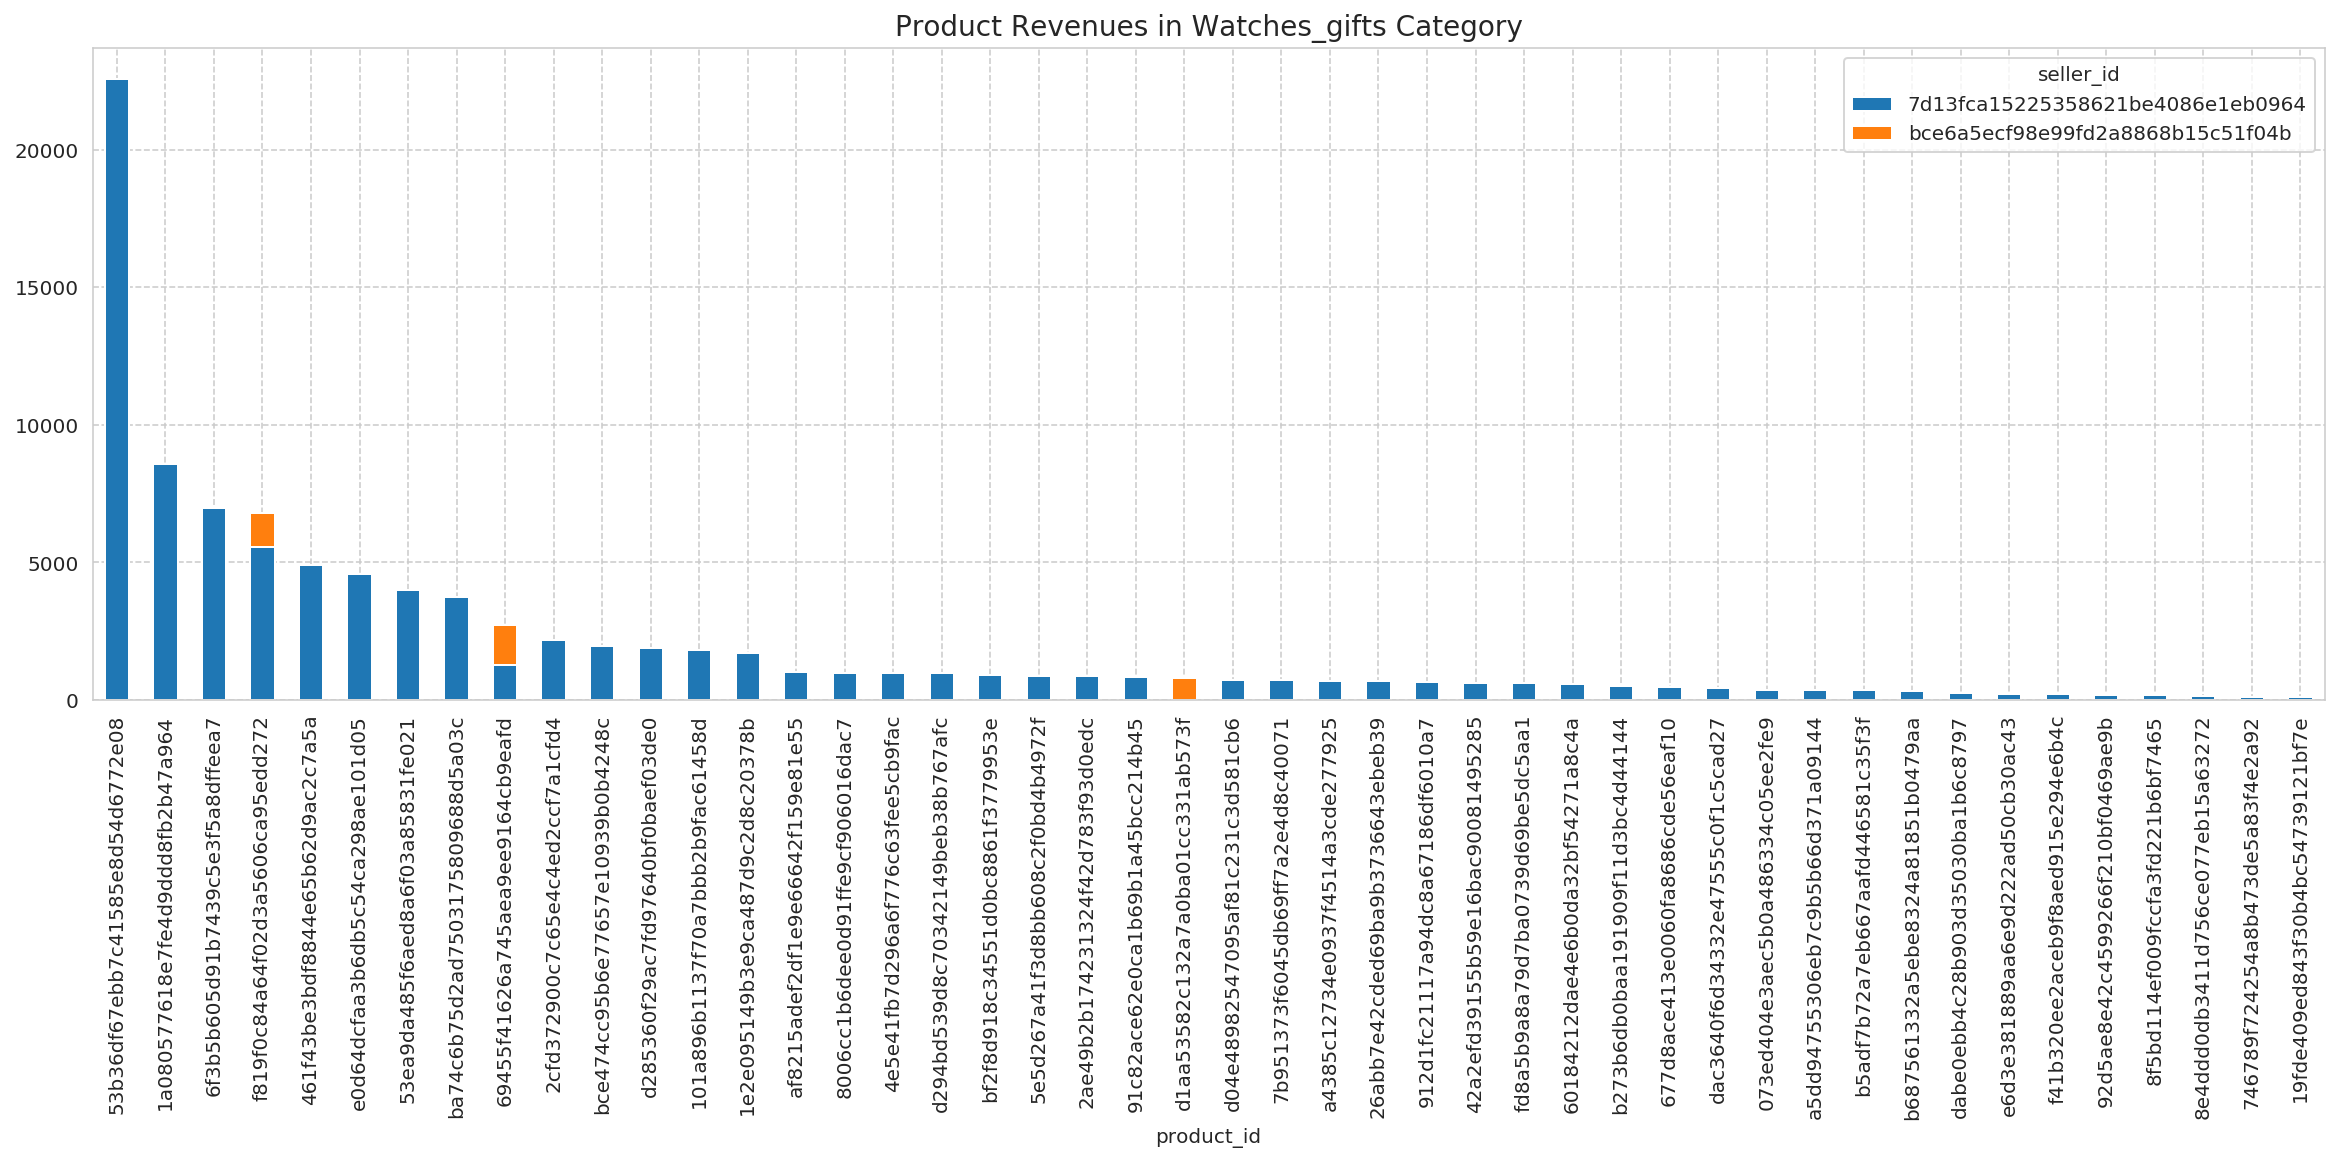

In [42]:
product_seller_revenue.plot.bar(stacked=True, figsize=(20, 6))
plt.title('Product Revenues in Watches_gifts Category', fontsize=14);

+ With 46 items in 'watches gifts' category, the top selling product accounts for 24.4% and five best-selling items form 53.9% of category revenue.
+ 'watches_gifts' may be a relatively homogeneous market so securing popular items is more important than pursuing a broad range of products. It implies that a category leader should be acquired to boost category revenue.